In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Lambda, Conv2D, MaxPooling2D, Bidirectional, LSTM, ConvLSTM2D, Flatten
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer


In [2]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')

# train = pd.concat([train, val])

print(train.shape)
print(val.shape)
print(test.shape)

# Make validation set imbalanced
val_pos = val[val['label'] == 1]
val_neg = val[val['label'] == 0]

val_pos = val_pos.sample(frac=0.1, random_state=4)

val = pd.concat([val_pos, val_neg])

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(8411, 6)
(935, 6)
(3226, 6)
(8411, 1024)
(490, 1024)
(3226, 1024)
(8411, 20)
(490, 20)
(3226, 20)
(8411, 33)
(490, 33)
(3226, 33)
(8411,)
(490,)
(3226,)


In [6]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1


RF:
Accuracy: 0.6633
MCC: 0.2299
AUC: 0.6859
AUPRC: 0.1630
Precision: 0.1882
Recall: 0.7143
Specificity: 0.6576
F1 Score: 0.2979

SVM:
Accuracy: 0.7245
MCC: 0.2833
AUC: 0.7200
AUPRC: 0.1888
Precision: 0.2244
Recall: 0.7143
Specificity: 0.7256
F1 Score: 0.3415

XGBoost:
Accuracy: 0.7000
MCC: 0.2822
AUC: 0.7245
AUPRC: 0.1869
Precision: 0.2151
Recall: 0.7551
Specificity: 0.6939
F1 Score: 0.3348

MLP:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.7367
MCC: 0.3165
AUC: 0.7449
AUPRC: 0.3103
Precision: 0.2403
Recall: 0.7551
Specificity: 0.7347
F1 Score: 0.3645

CNN:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Accuracy: 0.6735
MCC: 0.2382
AUC: 0.6916
AUPRC: 0.2538
Precision: 0.1934
Recall: 0.7143
Specificity: 0.6689
F1 Score: 0.3043

Results:

RF:
Accuracy: 0.6633
MCC: 0.2299
AUC: 0.6859
AUPRC: 0.1630
Precision: 0.1882
Recall: 0.7143
Specificity: 0.6576
F1: 0.2979

SVM:
Accuracy: 0.7245
MCC: 0.2833
AUC: 0.7200
AUPRC: 0.1888
Precision: 0.2244
Recall: 0.7143
Specificity: 0.7256
F1: 0.3415

XG

<Axes: title={'center': 'Model Performance'}>

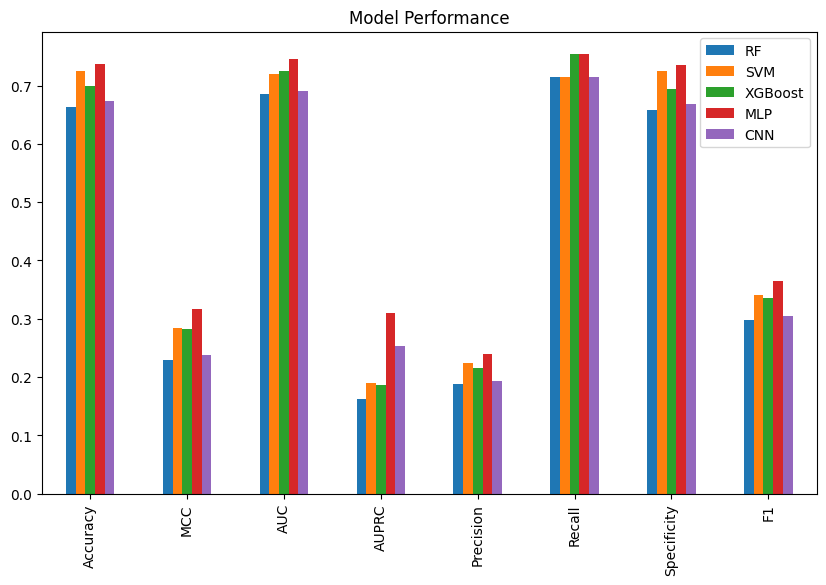

In [7]:
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Flatten, Attention, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

def create_MLP_model():
    input_shape = (1024,)  # 1024 features
    inputs = Input(shape=input_shape)

    dense1 = Dense(256, activation='relu')(inputs)
    dropout1 = Dropout(0.4)(dense1)
    dense2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.4)(dense2)
    dense3 = Dense(32, activation='relu')(dropout2)
    outputs = Dense(1, activation='sigmoid')(dense3)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_CNN_model():
    input_shape = (1024, 1)  # 1024 features with 1 channel
    inputs = Input(shape=input_shape)

    conv1 = Conv1D(256, 3, activation='relu')(inputs)
    pool1 = MaxPooling1D(3)(conv1)
    conv2 = Conv1D(128, 3, activation='relu')(pool1)
    pool2 = MaxPooling1D(3)(conv2)
    conv3 = Conv1D(64, 3, activation='relu')(pool2)
    pool3 = MaxPooling1D(3)(conv3)
    flat = Flatten()(pool3)
    dense1 = Dense(256, activation='relu')(flat)
    outputs = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# The training and evaluation part remains the same
model_names = [ 'RF', 'SVM', 'XGBoost', 'MLP', 'CNN' ]

# Create a dictionary to store the results
results = {name: [] for name in model_names}

# Train and evaluate the models
for name in model_names:
    print(f'\n{name}:')
    if name in ['RF', 'SVM', 'XGBoost']:
        if name == 'RF':
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif name == 'SVM':
            model = SVC(random_state=42)
        elif name == 'XGBoost':
            model = XGBClassifier(random_state=42)
        model.fit(X_train_embeddings, y_train)
        results[name] = evaluate_model(model, X_val=X_val_embeddings, y_val=y_val)
    else:
        if name == 'MLP':
            model = create_MLP_model()
        elif name == 'CNN':
            model = create_CNN_model()
            X_train_embeddings = X_train_embeddings.reshape(-1, 1024, 1)
            X_val_embeddings = X_val_embeddings.reshape(-1, 1024, 1)
            X_test_embeddings = X_test_embeddings.reshape(-1, 1024, 1)
        model.fit(X_train_embeddings, y_train, batch_size=64, epochs=50, verbose=0)
        results[name] = evaluate_model(model, X_val=X_val_embeddings, y_val=y_val)

# Print the results
print('\nResults:')
for name in model_names:
    print(f'\n{name}:')
    for metric, result in zip(['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Precision', 'Recall', 'Specificity', 'F1'], results[name]):
        print(f'{metric}: {result:.4f}')

# Plot the results using df.plot
results_df = pd.DataFrame(results, index=['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Precision', 'Recall', 'Specificity', 'F1'])


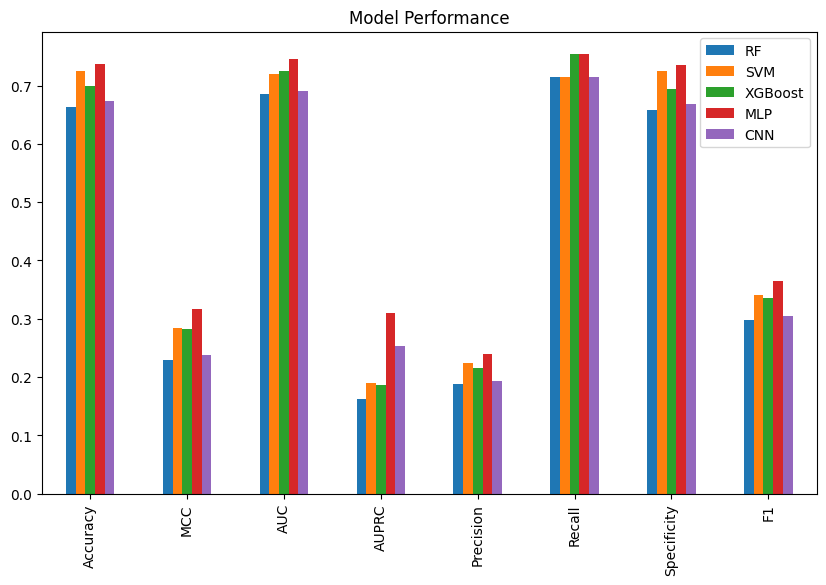

In [9]:
results_df.plot(kind='bar', figsize=(10, 6), title='Model Performance')

plt.savefig('prot_t5_model_selection.pdf', format='pdf', bbox_inches='tight')